In [1]:
cd ..

m:\OneDrive\Projects\federated_imputation


In [2]:
from src.modules.data_preprocessing import load_data

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
import pandas as pd
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.model_selection import StratifiedKFold
from dython.nominal import correlation_ratio
import itertools as it
import random
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from scipy import optimize
from scipy.special import expit

In [4]:
def eval_LR(X_train, y_train, X_test, y_test, seed = 21):
    model = LogisticRegression(random_state=seed, solver='liblinear', multi_class='ovr', max_iter=1000)
    grid = {'C': [0.1, 1, 10, 100, 1000], 'penalty': ['l1', 'l2']}
    clf = GridSearchCV(model, grid, cv= StratifiedKFold(5), scoring='accuracy', n_jobs=-1)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return accuracy_score(y_test, y_pred)

def eval_svm(X_train, y_train, X_test, y_test, seed = 21):
    model = SVC(random_state=seed, kernel='rbf', probability=True)
    grid = {'C': [0.1, 1, 10, 100, 1000], 'gamma': [0.1, 0.01, 0.001, 0.0001]}
    clf = GridSearchCV(model, grid, cv=StratifiedKFold(5), scoring='accuracy', n_jobs=-1)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return accuracy_score(y_test, y_pred)

def eval_rf(X_train, y_train, X_test, y_test, seed = 21):
    model = RandomForestClassifier(random_state=seed, n_jobs=-1)
    grid = {'n_estimators': [10, 50, 100, 200, 500], 'max_depth': [2, 3, 5, 10, 20]}
    clf = GridSearchCV(model, grid, cv=StratifiedKFold(5), scoring='accuracy', n_jobs=-1)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return accuracy_score(y_test, y_pred)

## Missing Pattern PyAmpute

In [5]:
import missingno
from pyampute.ampute import MultivariateAmputation

In [6]:
def simulate_missing_patterns(train_data, config, ms_ratio, ms_patterns, ms_mech, ms_func, seed):
    if isinstance(ms_patterns, tuple):
        ms_patterns = [ms_patterns]
    
    if ms_mech in ['MCAR', 'MAR', 'MNAR']:

        ret = []
        for ms_pattern in ms_patterns:
            ret.append({"incomplete_vars": ms_pattern, "mechanism": ms_mech, "score_to_probability_func": ms_func})
        
        ma = MultivariateAmputation(prop=ms_ratio, patterns=ret, seed=seed)
        X_train = train_data.drop(config['target'], axis=1).values
        y_train = train_data[config['target']].values
        X_train_ms = ma.fit_transform(X_train)
    elif ms_mech == 'MARY':
        ret = []
        for ms_pattern in ms_patterns:
            ret.append({"incomplete_vars": ms_pattern, "mechanism": "MAR", "score_to_probability_func": ms_func})

        ma = MultivariateAmputation(prop=ms_ratio, patterns=ret, seed=seed)
        train_ms = ma.fit_transform(train_data.values)
        train_ms = pd.DataFrame(train_ms, columns=train_data.columns)
        X_train_ms = train_ms.drop(config['target'], axis=1).values
        y_train = train_ms[config['target']].values

    else:
         raise NotImplemented

    return X_train_ms, y_train

In [7]:
def evaluation(
        train_data, test_data, config, ms_patterns, ms_mech, ms_func, ms_ratio = 0.5, 
        r_seed = 21, n_rounds = 100
    ):
    for pattern in ms_patterns:
        print("missing pattern: ", pattern)
        clf_seed = r_seed
        simple_lr, simple_svm, iter_lr, iter_svm = [], [], [], []
        for seed in range(1, n_rounds+1):
            #print("===========================================================================================")
            # simulate missing data
            X_train_ms, y_train = simulate_missing_patterns(train_data, config, ms_ratio, pattern, ms_mech, ms_func, seed)
            X_test = test_data.drop(config['target'], axis=1).values
            y_test = test_data[config['target']].values
            #print(X_train_ms.shape, y_train.shape, X_test.shape, y_test.shape)

            X_train_imp_simple = SimpleImputer(missing_values=np.nan, strategy='mean').fit_transform(X_train_ms)
            min_values, max_values = np.nanmin(X_train_ms, axis=0), np.nanmax(X_train_ms, axis=0)
            X_train_imp_iter = IterativeImputer(
                random_state=seed, max_iter=50, min_value=min_values, max_value=max_values
            ).fit_transform(X_train_ms)

            #print("Simple Imputer")
            score = eval_LR(X_train_imp_simple, y_train, X_test, y_test, seed=clf_seed)
            simple_lr.append(score)
            score = eval_svm(X_train_imp_simple, y_train, X_test, y_test, seed=clf_seed)
            simple_svm.append(score)
            #print("Iterative")
            score = eval_LR(X_train_imp_iter, y_train, X_test, y_test, seed=clf_seed)
            iter_lr.append(score)
            score = eval_svm(X_train_imp_iter, y_train, X_test, y_test, seed=clf_seed)
            iter_svm.append(score)
        print("Simple lr {}({}) svm {}({})".format(np.mean(simple_lr), np.std(simple_lr), np.mean(simple_svm), np.std(simple_svm)))
        print("Iter lr {}({}) svm {}({})".format(np.mean(iter_lr), np.std(iter_lr), np.mean(iter_svm), np.std(iter_svm)))

## MAR Missing Design

### Quantile

In [27]:
def mask_mar_quantile(data, cols, obs_cols, missing_ratio, missing_func, obs, seed, strict, y=None):

	mask = np.zeros(data.shape, dtype=bool)
	# for every column find the most correlated columns of the rest
	for col in cols:

		# set the seed
		seed = (seed + 10087651) % (2 ** 32 - 1)
		random.seed(seed)
		np.random.seed(seed)

		# find the most correlated column
		if y is not None:
			most_correlated_col_idx = data.shape[1] - 1
			data_corr = data[:, most_correlated_col_idx]
		else:
			if obs:
				X_rest = data[:, obs_cols]
			else:
				X_rest = data[:, np.arange(data.shape[1]) != col]

			score = mutual_info_regression(
				X_rest, data[:, col], discrete_features=False, n_neighbors=5, copy=True, random_state=seed
			)
			most_correlated_col_idx = np.argmax(score)
			data_corr = X_rest[:, most_correlated_col_idx]

		# find the quantile of the most correlated column
		if missing_func == 'random':
			missing_func = random.choice(['left', 'right', 'mid', 'tail'])

		if strict:
			total_missing = int(missing_ratio * data.shape[0])
			sorted_values = np.sort(data_corr)
			if missing_func == 'left':
				q = sorted_values[int(missing_ratio * data.shape[0]) - 1]
				indices = np.where(data_corr < q)[0]
				#print(sorted_values)
				#print(q, len(indices), total_missing)
				if len(indices) < total_missing:
					end_indices = np.where(
						data_corr == q
					)[0]
					add_up_indices = np.random.choice(
						end_indices, size=total_missing - len(indices), replace=False
					)
					na_indices = np.concatenate((indices, add_up_indices))
				elif len(indices) > total_missing:
					na_indices = np.random.choice(
						indices, size=total_missing, replace=False
					)
				else:
					na_indices = indices
			elif missing_func == 'right':
				q = sorted_values[int((1 - missing_ratio) * data.shape[0])]
				indices = np.where(data_corr > q)[0]
				if len(indices) < total_missing:
					start_indices = np.where(
						data_corr == q
					)[0]
					add_up_indices = np.random.choice(
						start_indices, size=total_missing - len(indices), replace=False
					)
					na_indices = np.concatenate((indices, add_up_indices))
				elif len(indices) > total_missing:
					na_indices = np.random.choice(
						indices, size=total_missing, replace=False
					)
				else:
					na_indices = indices
			elif missing_func == 'mid' or missing_func == 'tail':
				q0 = sorted_values[int((1 - missing_ratio) / 2 * data.shape[0])]
				q1 = sorted_values[int((1 + missing_ratio) / 2 * data.shape[0]) - 1]
				if missing_func == 'mid':
					indices = np.where(
						(data_corr> q0) & (data_corr < q1))[0]
				else:
					indices = np.where(
						(data_corr < q0) | (data_corr > q1))[0]
				if len(indices) < total_missing:
					end_indices_q0 = np.where(data_corr == q0)[0]
					end_indices_q1 = np.where(data_corr == q1)[0]
					end_indices = np.union1d(
						end_indices_q0, end_indices_q1
					)
					add_up_indices = np.random.choice(
						end_indices, size=total_missing - len(indices), replace=False
					)
					na_indices = np.concatenate((indices, add_up_indices))
				elif len(indices) > total_missing:
					na_indices = np.random.choice(
						indices, size=total_missing, replace=False
					)
				else:
					na_indices = indices
			else:
				raise NotImplementedError
		else:
			if missing_func == 'left':
				q0 = 0
				q1 = 0.5 if missing_ratio <= 0.5 else missing_ratio
			elif missing_func == 'right':
				q0 = 0.5 if missing_ratio <= 0.5 else 1 - missing_ratio
				q1 = 1
			elif missing_func == 'mid' or missing_func == 'tail':
				q0 = 0.25 if missing_ratio <= 0.5 else 0.5 - missing_ratio / 2
				q1 = 0.75 if missing_ratio <= 0.5 else 0.5 + missing_ratio / 2
			else:
				raise NotImplementedError

			sorted_values = np.sort(data_corr)
			q0 = sorted_values[int(q0 * data.shape[0])]
			q1 = sorted_values[int(q1 * data.shape[0]) - 1]

			if missing_func != 'tail':
				indices = np.where(
					(data_corr >= q0) & (data_corr <= q1))[0]
			else:
				indices = np.where(
					(data_corr <= q0) | (data_corr >= q1))[0]
			na_indices = np.random.choice(
				indices, size=int(missing_ratio * data.shape[0]), replace=False
			)

		# if missing_func != 'tail':
		# 	indices = np.where((data[:, most_correlated_col_idx] >= q0) & (data[:, most_correlated_col_idx] <= q1))[0]
		# else:
		# 	indices = np.where((data[:, most_correlated_col_idx] <= q0) | (data[:, most_correlated_col_idx] >= q1))[0]

		# sorted_indices = np.argsort(data[:, most_correlated_col_idx])
		# if missing_func != 'tail':
		# 	indices = sorted_indices[int(q0*data.shape[0]):int(q1*data.shape[0])]
		# else:
		# 	indices = np.concatenate((sorted_indices[:int(q0*data.shape[0])], sorted_indices[int(q1*data.shape[0]):]))

		# assign the missing values
		# print(q0, q1, len(indices), len(data))
		# if (int(missing_ratio*data.shape[0])) <= len(indices):
		# 	na_indices = random.sample(list(indices), int(missing_ratio*data.shape[0]))
		# else:
		# 	na_indices = indices

		# mary
		# sorted_indices = np.argsort(target_series)
		# if missing_func != 'tail':
		# 	indices = sorted_indices[int(q0*data.shape[0]):int(q1*data.shape[0])]
		# else:
		# 	indices = np.concatenate((sorted_indices[:int(q0*data.shape[0])], sorted_indices[int(q1*data.shape[0]):]))

		# # assign the missing values
		# if (int(missing_ratio*data.shape[0])) <= len(indices):
		# 	na_indices = random.sample(list(indices), int(missing_ratio*data.shape[0]))
		# else:
		# 	na_indices = indices
		# mask[na_indices, col] = True

		mask[na_indices, col] = True

	return mask

In [16]:
def simulate_nan_mar_quantile(
		data, cols, missing_ratio, missing_func = 'left', obs = False, strict = True, seed=201030
	):

	# find the columns that are not to be adding missing values
	obs_cols = []
	for index in range(data.shape[1]):
		if index not in cols:
			obs_cols.append(index)
	obs_cols = np.array(obs_cols)
	if obs and len(obs_cols) == 0:
		raise ValueError("No columns to observe, try to set obs to be False")

	# get mask based on quantile
	mask = mask_mar_quantile(data, cols, obs_cols, missing_ratio, missing_func, obs, seed, strict)
	
	# assign the missing values
	data_ms = data.copy()
	data_ms[mask] = np.nan

	return data_ms


In [18]:
def simulate_nan_mary_quantile(
		data, cols, missing_ratio, missing_func = 'left', strict = True, seed=201030
	):


	mask = mask_mar_quantile(
		data, cols, obs_cols= None, missing_ratio = missing_ratio, missing_func = missing_func, obs = False, 
		seed = seed, strict = strict, y = True)
	
	# assign the missing values
	data_ms = data.copy()
	data_ms[mask] = np.nan

	return data_ms

### Sigmoid

In [45]:
def mask_mar_sigmoid(mask, col, data_corr, missing_ratio, missing_func, strict, seed):
	np.random.seed(seed)
	random.seed(seed)
	#################################################################################
	# pick coefficients
	#################################################################################
	# Pick coefficients so that W^Tx has unit variance (avoids shrinking)

	# copy data and do min-max normalization
	data_copy = data_corr.copy()
	data_copy = (data_copy - data_copy.min(0, keepdims=True)) / (
			data_copy.max(0, keepdims=True) - data_copy.min(0, keepdims=True))
	data_copy = (data_copy - data_copy.mean(0, keepdims=True)) / data_copy.std(0, keepdims=True)

	coeffs = np.random.rand(data_copy.shape[1], 1)
	# print(coeffs)
	Wx = data_copy @ coeffs
	# print(Wx)
	wss = (Wx) / np.std(Wx, 0, keepdims=True)

	def f(x: np.ndarray) -> np.ndarray:
		if missing_func == 'left':
			return expit(-wss + x).mean().item() - missing_ratio
		elif missing_func == 'right':
			return expit(wss + x).mean().item() - missing_ratio
		elif missing_func == 'mid':
			return expit(np.absolute(wss) - 0.75 + x).mean().item() - missing_ratio
		elif missing_func == 'tail':
			return expit(-np.absolute(wss) + 0.75 + x).mean().item() - missing_ratio
		else:
			raise NotImplementedError

	intercept = optimize.bisect(f, -50, 50)

	if missing_func == 'left':
		ps = expit(-wss + intercept)
	elif missing_func == 'right':
		ps = expit(wss + intercept)
	elif missing_func == 'mid':
		ps = expit(-np.absolute(wss) + 0.75 + intercept)
	elif missing_func == 'tail':
		ps = expit(np.absolute(wss) - 0.75 + intercept)
	else:
		raise NotImplementedError

	# strict false means using random simulation
	if strict is False:
		ber = np.random.binomial(n=1, size=mask.shape[0], p=ps.flatten())
		mask[:, col] = ber
	# strict mode based on rank on calculated probability, strictly made missing
	else:
		ps = ps.flatten()
		# print(ps)
		end_value = np.sort(ps)[::-1][int(missing_ratio * data_copy.shape[0])]
		indices = np.where((ps - end_value) > 1e-3)[0]
		# print(len(indices), int(missing_ratio*data_copy.shape[0]), len(np.where(np.absolute(ps - end_value) <=
		# 1e-3)[0]))
		if len(indices) < int(missing_ratio * data_copy.shape[0]):
			end_indices = np.where(np.absolute(ps - end_value) <= 1e-3)[0]
			end_indices = np.random.choice(
				end_indices, int(missing_ratio * data_copy.shape[0]) - len(indices), replace=False
			)
			indices = np.concatenate((indices, end_indices))
		elif len(indices) > int(missing_ratio * data_copy.shape[0]):
			indices = np.random.choice(indices, int(missing_ratio * data_copy.shape[0]), replace=False)

		mask[indices, col] = True

	return mask

In [46]:
def simulate_nan_mar_sigmoid(data, cols, missing_ratio, missing_func, obs, k, strict = False, seed = 1002031):
    
    mask = np.zeros(data.shape, dtype=bool)
    
    # add missing for each columns
    for col in cols:
        
        # set the seed
        seed = (seed + 1203941)%(2^32-1)

        ##################################################################################
        # na associated with only observed columns
        if obs is True:
            keep_mask = np.ones(data.shape[1], dtype=bool)
            keep_mask[list(cols)] = False
            X_rest = data[:, keep_mask]
        # na associated with all other columns
        else:
            X_rest = data[:, np.arange(data.shape[1]) != col]
        
        #################################################################################
        # get k most correlated columns or all columns
        if k == 'all' or k >= X_rest.shape[1]:
            indices_obs = np.arange(data.shape[1])
            indices_obs = np.setdiff1d(indices_obs, cols)
            data_corr = data[:, indices_obs]
        else:
            score = mutual_info_regression(
                X_rest, data[:, col], discrete_features=False, n_neighbors=5, copy=True, random_state=seed)
            indices_obs = np.argsort(score)[::-1][:k]
            data_corr = X_rest[:, indices_obs]
        
        #################################################################################
        # pick coefficients and mask missing values
        #################################################################################
        mask= mask_mar_sigmoid(mask, col, data_corr, missing_ratio, missing_func, strict, seed)
    
    # assign the missing values
    data_ms = data.copy()
    data_ms[mask] = np.nan
    
    return data_ms

In [47]:
def simulate_nan_mary_sigmoid(data, cols, missing_ratio, missing_func, strict = False, seed = 1002031):
    
    mask = np.zeros(data.shape, dtype=bool)
    
    # add missing for each columns
    for col in cols:
        
        # set the seed
        seed = (seed + 1203941)%(2^32-1)
        # missing is associated with last column is the target
        indices_obs = [data.shape[1]-1]
        data_corr= data[:, indices_obs]

        #################################################################################
        # pick coefficients and mask missing values
        #################################################################################
        mask= mask_mar_sigmoid(mask, col, data_corr, missing_ratio, missing_func, strict, seed)
    
    # assign the missing values
    data_ms = data.copy()
    data_ms[mask] = np.nan
    
    return data_ms

### Example

In [52]:
X = np.array([
    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], 
    [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
    ], dtype=float).T

X = np.array([
    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], 
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 0.6, 0.6, 0.6, 0.6, 5, 6, 1, 1, 1, 1, 1],
    [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 5, 6, 7, 8, 9, 10, 11]
    ], dtype=float).T

X_ms = simulate_nan_mar_sigmoid(X, [0], 0.5, 'right', True, 1, strict = True, seed=1002031)
X_ms

array([[ 1. ,  1. ,  0.1],
       [ 2. ,  1. ,  0.2],
       [ 3. ,  1. ,  0.3],
       [ 4. ,  1. ,  0.4],
       [ 5. ,  1. ,  0.5],
       [ 6. ,  1. ,  0.6],
       [ nan,  1. ,  0.6],
       [ nan,  1. ,  0.6],
       [ 9. ,  1. ,  0.6],
       [10. ,  0.6,  0.6],
       [11. ,  0.6,  0.6],
       [ nan,  0.6,  0.6],
       [13. ,  0.6,  0.6],
       [ nan,  5. ,  5. ],
       [ nan,  6. ,  6. ],
       [ nan,  1. ,  7. ],
       [ nan,  1. ,  8. ],
       [ nan,  1. ,  9. ],
       [ nan,  1. , 10. ],
       [ nan,  1. , 11. ]])

In [29]:
X = np.array([
    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
    [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 5, 6, 7, 8, 9, 10, 11]
    ], dtype=float).T

X_ms = simulate_nan_mar_quantile(
    data = X, cols = [0], missing_ratio = 0.5, missing_func = 'left', 
    obs = True, strict = False, seed=1002031)
X_ms

array([[ nan,  0.1],
       [ nan,  0.2],
       [ nan,  0.3],
       [ nan,  0.4],
       [ nan,  0.5],
       [ nan,  0.6],
       [ 7. ,  0.6],
       [ 8. ,  0.6],
       [ nan,  0.6],
       [ nan,  0.6],
       [ nan,  0.6],
       [12. ,  0.6],
       [ nan,  0.6],
       [14. ,  5. ],
       [15. ,  6. ],
       [16. ,  7. ],
       [17. ,  8. ],
       [18. ,  9. ],
       [19. , 10. ],
       [20. , 11. ]])

In [42]:
X = np.array([
    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], 
    [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
    [0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,2,2,2,2,2]
    ], dtype=float).T

X_ms = simulate_nan_mary_sigmoid(X, [0], 0.5, 'left', strict = True, seed=1002031)
X_ms

array([[ nan,  0.1,  0. ],
       [ nan,  0.2,  0. ],
       [ nan,  0.3,  0. ],
       [ nan,  0.4,  0. ],
       [ nan,  0.5,  0. ],
       [ nan,  0.6,  0. ],
       [ nan,  0.7,  0. ],
       [ 8. ,  0.8,  1. ],
       [ nan,  0.9,  1. ],
       [ nan,  1. ,  1. ],
       [11. ,  2. ,  1. ],
       [12. ,  3. ,  1. ],
       [13. ,  4. ,  1. ],
       [ nan,  5. ,  1. ],
       [15. ,  6. ,  1. ],
       [16. ,  7. ,  2. ],
       [17. ,  8. ,  2. ],
       [18. ,  9. ,  2. ],
       [19. , 10. ,  2. ],
       [20. , 11. ,  2. ]])

### Evaluation_mar

In [626]:
def evaluation_mar(
        train_data, test_data, config, cols_list, ms_mech, ms_func, ms_ratio = 0.5,
        strict = True, r_seed = 21, n_rounds = 100, obs = False
    ):
    for cols in cols_list:
        print("Columns: ", cols)
        clf_seed = r_seed
        simple_lr, simple_svm, iter_lr, iter_svm = [], [], [], []
        for seed in range(1, n_rounds+1):
            #print("===========================================================================================")
            # simulate missing data
            X_train = train_data.drop(config['target'], axis=1).values
            y_train = train_data[config['target']].values
            if ms_mech == 'MAR':
                X_train_ms = simulate_nan_mar_quantile(X_train, cols, ms_ratio, ms_func, obs, strict, seed)
            elif ms_mech == 'MARY':
                train_data_ms = simulate_nan_mary_quantile(train_data.values, cols, ms_ratio, ms_func, strict, seed)
                X_train_ms = train_data_ms[:, :-1]
            elif ms_mech == 'MAR_sigmoid':
                X_train_ms = simulate_nan_mar_sigmoid(X_train, cols, ms_ratio, ms_func, obs, k = 'all', strict = strict, seed = seed)
            elif ms_mech == 'MARY_sigmoid':
                train_data_ms = simulate_nan_mary_sigmoid(train_data.values, cols, ms_ratio, ms_func, strict, seed)
                X_train_ms = train_data_ms[:, :-1]
            else:
                raise NotImplemented
            X_test = test_data.drop(config['target'], axis=1).values
            y_test = test_data[config['target']].values
            #print(X_train_ms.shape, y_train.shape, X_test.shape, y_test.shape)

            X_train_imp_simple = SimpleImputer(missing_values=np.nan, strategy='mean').fit_transform(X_train_ms)
            min_values, max_values = np.nanmin(X_train_ms, axis=0), np.nanmax(X_train_ms, axis=0)
            X_train_imp_iter = IterativeImputer(
                random_state=seed, max_iter=50, min_value=min_values, max_value=max_values
            ).fit_transform(X_train_ms)

            #print("Simple Imputer")
            score = eval_LR(X_train_imp_simple, y_train, X_test, y_test, seed=clf_seed)
            simple_lr.append(score)
            score = eval_svm(X_train_imp_simple, y_train, X_test, y_test, seed=clf_seed)
            simple_svm.append(score)
            #print("Iterative")
            score = eval_LR(X_train_imp_iter, y_train, X_test, y_test, seed=clf_seed)
            iter_lr.append(score)
            score = eval_svm(X_train_imp_iter, y_train, X_test, y_test, seed=clf_seed)
            iter_svm.append(score)
        print("Simple lr {}({}) svm {}({})".format(np.mean(simple_lr), np.std(simple_lr), np.mean(simple_svm), np.std(simple_svm)))
        print("Iter lr {}({}) svm {}({})".format(np.mean(iter_lr), np.std(iter_lr), np.mean(iter_svm), np.std(iter_svm)))

## Iris

In [10]:
data, config = load_data('iris')
print(data.columns)
print(config)
seed = 21
train_data, test_data = train_test_split(data, test_size=0.15, random_state=seed, shuffle=True, stratify=data[config['target']])
print(train_data.shape, test_data.shape)
correlation_ret = data.corrwith(data[config['target']], method=correlation_ratio).sort_values(ascending=False)
feature_idx_sort_corr = [data.columns.tolist().index(col) for col in correlation_ret.index.tolist() if col != config['target']]
print("Feature index sorted by correlation {}".format(feature_idx_sort_corr))
correlation_ret

Index(['1', '2', '3', '4', '5'], dtype='object')
{'target': '5', 'important_features_idx': [2, 3, 0, 1], 'features_idx': [0, 1, 2, 3, 4], 'num_cols': 4, 'task_type': 'classification', 'clf_type': 'multi-class', 'data_type': 'tabular'}
(127, 5) (23, 5)
Feature index sorted by correlation [2, 3, 0, 1]


5    1.000000
3    0.970216
4    0.963761
1    0.786578
2    0.626004
dtype: float64

### Test Missing Function

2023-03-21 16:00:33,352 [WARNING] Candidates for pattern 0 all have almost the same weighted sum scores. It is possible this is due to the use of binary variables in amputation. This creates problems when using the sigmoid function for the score_to_probability_func. Currently our solution is as follows: if there is just one candidate with a sum score 0, we will ampute it. If there is one candidate with a nonzero sum score, or multiple candidates with the same score, we evenly apply as if MCAR.


<AxesSubplot: >

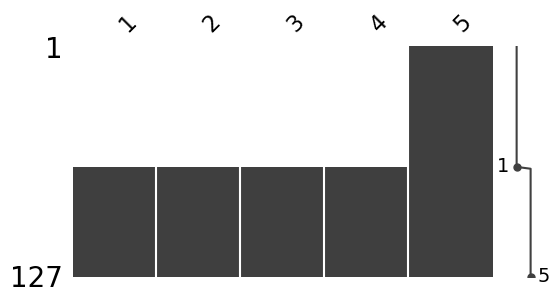

In [135]:
mechs = ["MARY"]
funcs = ["sigmoid-right", "sigmoid-mid", "sigmoid-left", "sigmoid-tail"]
func = funcs[3]
incomplete_vars = [(0, 1, 2, 3),]
missing_ratio = 0.5

X_train_ms, y_train = simulate_missing_patterns(train_data, config, ms_ratio=missing_ratio, ms_patterns=incomplete_vars, ms_mech=mechs[0], ms_func=func, seed=seed)

train_data_ms = pd.DataFrame(np.hstack([X_train_ms, np.expand_dims(y_train, 1)]), columns=train_data.columns)
missingno.matrix(train_data_ms, sort='ascending', figsize=(6, 3))

<AxesSubplot: >

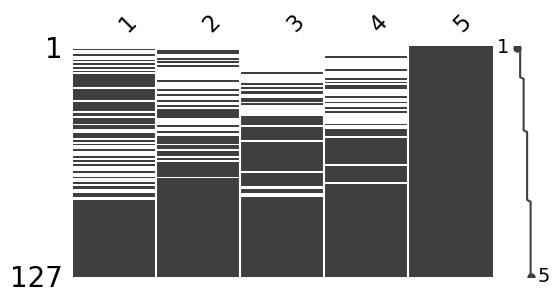

In [491]:
mechs = ["MARY"]
funcs = ["sigmoid-right", "sigmoid-mid", "sigmoid-left", "sigmoid-tail"]
func = funcs[3]
incomplete_vars = [(0, 1, 2, 3),]
missing_ratio = 0.3
seed = 35
X_train = train_data.drop(config['target'], axis=1).values
y_train = train_data[config['target']].values
X_train_ms = simulate_nan_mar_quantile(
    X_train, missing_ratio=missing_ratio, cols=incomplete_vars[0], missing_func='tail', obs = False, strict = False, seed=seed)
#X_train_ms, y_train = simulate_missing_patterns(train_data, config, ms_ratio=missing_ratio, ms_patterns=incomplete_vars, ms_mech=mechs[0], ms_func=func, seed=seed)

train_data_ms = pd.DataFrame(np.hstack([X_train_ms, np.expand_dims(y_train, 1)]), columns=train_data.columns)
missingno.matrix(train_data_ms, sort='ascending', figsize=(6, 3))

<AxesSubplot: >

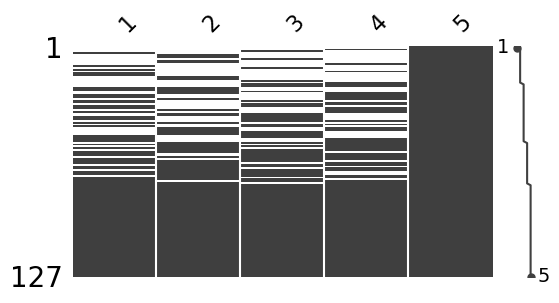

In [540]:
incomplete_vars = [(0, 1, 2, 3),]
missing_ratio = 0.3
seed = 35
train_data_ms = simulate_nan_mary_quantile(
    train_data.values, cols=incomplete_vars[0], missing_ratio=missing_ratio, missing_func='right', strict = False, seed=seed)
#X_train_ms, y_train = simulate_missing_patterns(train_data, config, ms_ratio=missing_ratio, ms_patterns=incomplete_vars, ms_mech=mechs[0], ms_func=func, seed=seed)

train_data_ms = pd.DataFrame(train_data_ms, columns=train_data.columns)
missingno.matrix(train_data_ms, sort='ascending', figsize=(6, 3))

<AxesSubplot: >

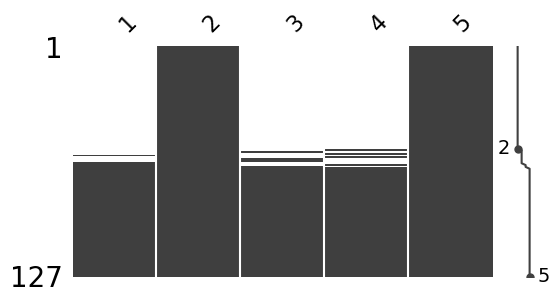

In [622]:
incomplete_vars = [(0, 2, 3),]
missing_ratio = 0.5
seed = 34
X_train = train_data.drop(config['target'], axis=1).values
y_train = train_data[config['target']].values
X_train_ms = simulate_nan_mar_sigmoid(
    X_train, cols = incomplete_vars[0], missing_ratio=missing_ratio, missing_func='left', obs = True, k = 2, strict = True, seed=seed)

train_data_ms = pd.DataFrame(np.hstack([X_train_ms, np.expand_dims(y_train, 1)]), columns=train_data.columns)
missingno.matrix(train_data_ms, sort = 'ascending', figsize=(6, 3))

<AxesSubplot: >

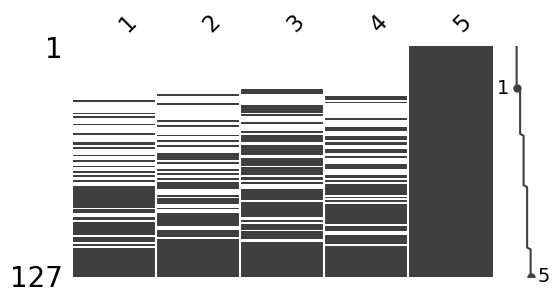

In [630]:
incomplete_vars = [(0, 1, 2, 3),]
missing_ratio = 0.5
seed = 35
X_train = train_data.drop(config['target'], axis=1).values
y_train = train_data[config['target']].values
X_train_ms = simulate_nan_mary_sigmoid(
    X_train, cols = incomplete_vars[0], missing_ratio=missing_ratio, missing_func='left', strict = False, seed=seed)

train_data_ms = pd.DataFrame(np.hstack([X_train_ms, np.expand_dims(y_train, 1)]), columns=train_data.columns)
missingno.matrix(train_data_ms, sort = 'ascending', figsize=(6, 3))

### Missing Pattern

In [60]:
# get all missing patterns
ms_mech = "MARY"
funcs = ["sigmoid-right", "sigmoid-mid", "sigmoid-left", "sigmoid-tail"]
ms_func = funcs[3]
ms_ratio = 0.5

import warnings
warnings.filterwarnings("ignore")
'''
missing ratio:  0.5
Simple lr 0.782169521299956(0.015749162123004933) svm 0.8102766798418971(0.05438673897378205)
Iter lr 0.856829161176987(0.07079839273214451) svm 0.9363197189284146(0.05032332546554667)
'''
for n_features in range(3, 5):
    patterns = list(it.combinations(feature_idx_sort_corr, n_features))
    evaluation(train_data, test_data, config, patterns, ms_mech, ms_func, ms_ratio = ms_ratio, 
        r_seed = 21, n_rounds=50)

missing pattern:  (2, 3, 0)
Simple lr 0.7947826086956523(0.036933496663644004) svm 0.9130434782608694(0.05360360002581719)
Iter lr 0.8321739130434783(0.05431129206826848) svm 0.8773913043478261(0.08594630582999077)
missing pattern:  (2, 3, 1)
Simple lr 0.8095652173913044(0.04592259452699441) svm 0.7895652173913044(0.06642931914707575)
Iter lr 0.8817391304347827(0.05638109592155592) svm 0.9469565217391305(0.03718853005277062)
missing pattern:  (2, 0, 1)
Simple lr 0.9730434782608696(0.024425342443805453) svm 0.9782608695652175(0.021739130434782594)
Iter lr 0.9539130434782609(0.02667454200030953) svm 0.9434782608695652(0.027839670597534148)
missing pattern:  (3, 0, 1)


2023-03-21 14:41:19,853 [WARNING] Candidates for pattern 0 all have almost the same weighted sum scores. It is possible this is due to the use of binary variables in amputation. This creates problems when using the sigmoid function for the score_to_probability_func. Currently our solution is as follows: if there is just one candidate with a sum score 0, we will ampute it. If there is one candidate with a nonzero sum score, or multiple candidates with the same score, we evenly apply as if MCAR.


Simple lr 0.9495652173913044(0.01815705479810533) svm 0.9382608695652174(0.02762153073785845)
Iter lr 0.9547826086956522(0.021228792375189067) svm 0.9426086956521739(0.02671702868823866)
missing pattern:  (2, 3, 0, 1)


2023-03-21 14:41:20,236 [WARNING] Candidates for pattern 0 all have almost the same weighted sum scores. It is possible this is due to the use of binary variables in amputation. This creates problems when using the sigmoid function for the score_to_probability_func. Currently our solution is as follows: if there is just one candidate with a sum score 0, we will ampute it. If there is one candidate with a nonzero sum score, or multiple candidates with the same score, we evenly apply as if MCAR.
2023-03-21 14:41:20,644 [WARNING] Candidates for pattern 0 all have almost the same weighted sum scores. It is possible this is due to the use of binary variables in amputation. This creates problems when using the sigmoid function for the score_to_probability_func. Currently our solution is as follows: if there is just one candidate with a sum score 0, we will ampute it. If there is one candidate with a nonzero sum score, or multiple candidates with the same score, we evenly apply as if MCAR.
20

Simple lr 0.8173913043478261(0.03984848430396381) svm 0.9504347826086956(0.04171194767030073)
Iter lr 0.8173913043478261(0.03984848430396381) svm 0.9504347826086956(0.04171194767030073)


In [49]:
def generate_all_patterns(feature_indices):
    ret = []
    for n_features in range(1, len(feature_indices)+1):
        patterns = list(it.combinations(feature_indices, n_features))
        ret.extend(patterns)
    return ret

In [50]:
# get all missing patterns
ms_mech = "MCAR"
funcs = ["sigmoid-right", "sigmoid-mid", "sigmoid-left", "sigmoid-tail"]
ms_func = funcs[3]
ms_ratio = 0.5

import warnings
warnings.filterwarnings("ignore")
'''
missing ratio:  0.5
Simple lr 0.782169521299956(0.015749162123004933) svm 0.8102766798418971(0.05438673897378205)
Iter lr 0.856829161176987(0.07079839273214451) svm 0.9363197189284146(0.05032332546554667)
'''
patterns = [[(2,3), (2,3,0), (2,3,1), (2,3,0,1)]]
evaluation(train_data, test_data, config, patterns, ms_mech, ms_func, ms_ratio = ms_ratio, 
    r_seed = 21, n_rounds=50)

patterns = [generate_all_patterns(feature_idx_sort_corr)]
evaluation(train_data, test_data, config, patterns, ms_mech, ms_func, ms_ratio = ms_ratio, 
    r_seed = 21, n_rounds=50)

missing pattern:  [(2, 3), (2, 3, 0), (2, 3, 1), (2, 3, 0, 1)]


2023-03-21 12:05:29,446 [WARNING] Subset for pattern 1 is small. Too many patterns can result in subsets with 0 or few candidates. Subsets with 0 candidates will be skipped. Under MCAR, subsets with few candidates will be amputed as normal.
2023-03-21 12:05:29,447 [WARNING] Subset for pattern 3 is small. Too many patterns can result in subsets with 0 or few candidates. Subsets with 0 candidates will be skipped. Under MCAR, subsets with few candidates will be amputed as normal.
2023-03-21 12:05:29,448 [WARNING] Subset for pattern 4 is small. Too many patterns can result in subsets with 0 or few candidates. Subsets with 0 candidates will be skipped. Under MCAR, subsets with few candidates will be amputed as normal.
2023-03-21 12:05:29,449 [WARNING] Subset for pattern 5 is small. Too many patterns can result in subsets with 0 or few candidates. Subsets with 0 candidates will be skipped. Under MCAR, subsets with few candidates will be amputed as normal.
2023-03-21 12:05:29,450 [WARNING] Su

Simple lr 0.8026086956521739(0.0360738582829418) svm 0.8513043478260869(0.08389839926283328)
Iter lr 0.8356521739130435(0.055875908961451615) svm 0.9373913043478261(0.03904338142720636)
missing pattern:  [(2,), (3,), (0,), (1,), (2, 3), (2, 0), (2, 1), (3, 0), (3, 1), (0, 1), (2, 3, 0), (2, 3, 1), (2, 0, 1), (3, 0, 1), (2, 3, 0, 1)]


2023-03-21 12:05:29,990 [WARNING] Subset for pattern 0 is small. Too many patterns can result in subsets with 0 or few candidates. Subsets with 0 candidates will be skipped. Under MCAR, subsets with few candidates will be amputed as normal.
2023-03-21 12:05:29,992 [WARNING] Subset for pattern 1 is small. Too many patterns can result in subsets with 0 or few candidates. Subsets with 0 candidates will be skipped. Under MCAR, subsets with few candidates will be amputed as normal.
2023-03-21 12:05:29,993 [WARNING] Subset for pattern 2 is small. Too many patterns can result in subsets with 0 or few candidates. Subsets with 0 candidates will be skipped. Under MCAR, subsets with few candidates will be amputed as normal.
2023-03-21 12:05:29,994 [WARNING] Subset for pattern 3 is small. Too many patterns can result in subsets with 0 or few candidates. Subsets with 0 candidates will be skipped. Under MCAR, subsets with few candidates will be amputed as normal.
2023-03-21 12:05:29,995 [WARNING] Su

Simple lr 0.8165217391304348(0.04542594047516164) svm 0.9200000000000002(0.05315028448673436)
Iter lr 0.9078260869565216(0.04734141770023026) svm 0.9521739130434783(0.029166104054345093)


### MAR quantile

In [500]:
cols_list = [(0, 1, 2, 3),]
ms_mech = "MAR"
ms_func = "right"
ms_ratio = 0.5
strict = False

for ms_ratio in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]:
    print("missing ratio: {}".format(ms_ratio))
    evaluation_mar(
        train_data, test_data, config, cols_list, ms_mech, ms_func, ms_ratio = ms_ratio, obs = False,
        strict = strict, r_seed = 21, n_rounds = 50
    )

missing ratio: 0.1
Columns:  (0, 1, 2, 3)
Simple lr 0.826086956521739(0.038888138739126756) svm 0.9260869565217391(0.021739130434782646)
Iter lr 0.9599999999999999(0.021013992997555783) svm 0.9530434782608697(0.014654173518567602)
missing ratio: 0.2
Columns:  (0, 1, 2, 3)
Simple lr 0.7895652173913044(0.02013189026572213) svm 0.88(0.06304197899266732)
Iter lr 0.9417391304347825(0.051156751582896454) svm 0.9591304347826087(0.013499282344573933)
missing ratio: 0.3
Columns:  (0, 1, 2, 3)
Simple lr 0.7765217391304347(0.030135171219414714) svm 0.8565217391304348(0.059772726455945724)
Iter lr 0.8539130434782608(0.06493271200902423) svm 0.9565217391304348(0.036892527714080754)
missing ratio: 0.4
Columns:  (0, 1, 2, 3)
Simple lr 0.6713043478260868(0.07736687450273122) svm 0.7695652173913043(0.06915640748081245)
Iter lr 0.7913043478260868(0.05070392952039392) svm 0.9(0.07183787670373178)
missing ratio: 0.5
Columns:  (0, 1, 2, 3)
Simple lr 0.631304347826087(0.02172173216834224) svm 0.648695652173

In [503]:
cols_list = [(0, 2, 3),]
ms_mech = "MAR"
ms_func = "right"
ms_ratio = 0.5
strict = False

for ms_ratio in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]:
    print("missing ratio: {}".format(ms_ratio))
    evaluation_mar(
        train_data, test_data, config, cols_list, ms_mech, ms_func, ms_ratio = ms_ratio, obs = False,
        strict = strict, r_seed = 21, n_rounds = 50
    )

missing ratio: 0.1
Columns:  (0, 2, 3)
Simple lr 0.8182608695652175(0.04142088822196364) svm 0.9278260869565217(0.022356452403795586)
Iter lr 0.9565217391304348(0.017391304347826098) svm 0.9573913043478263(0.006086956521739126)
missing ratio: 0.2
Columns:  (0, 2, 3)
Simple lr 0.7843478260869564(0.0173041293409847) svm 0.8860869565217391(0.05628042130533705)
Iter lr 0.9373913043478261(0.04361716940516333) svm 0.96(0.014654173518567579)
missing ratio: 0.3
Columns:  (0, 2, 3)
Simple lr 0.7782608695652173(0.024976359332774055) svm 0.8504347826086956(0.0634007865515067)
Iter lr 0.8547826086956524(0.05115675158289644) svm 0.9634782608695651(0.03725962658370183)
missing ratio: 0.4
Columns:  (0, 2, 3)
Simple lr 0.6982608695652174(0.07244579487249067) svm 0.7965217391304349(0.08131248506129361)
Iter lr 0.8156521739130433(0.05869404184586504) svm 0.9104347826086956(0.06354969179336858)
missing ratio: 0.5
Columns:  (0, 2, 3)
Simple lr 0.6504347826086956(0.008519964322724092) svm 0.652173913043478

### MARY quantile

In [545]:
cols_list = [(0, 1, 2, 3),]
ms_mech = "MARY"
ms_func = "right"
ms_ratio = 0.5
strict = False

for ms_ratio in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]:
    print("missing ratio: {}".format(ms_ratio))
    evaluation_mar(
        train_data, test_data, config, cols_list, ms_mech, ms_func, ms_ratio = ms_ratio, obs = True,
        strict = strict, r_seed = 21, n_rounds = 40
    )

missing ratio: 0.1
Columns:  (0, 1, 2, 3)
Simple lr 0.8695652173913043(0.046625240412015656) svm 0.9304347826086957(0.02341376003101962)
Iter lr 0.9576086956521739(0.011857295776777955) svm 0.9543478260869565(0.009475867268566699)
missing ratio: 0.2
Columns:  (0, 1, 2, 3)
Simple lr 0.7978260869565218(0.02488157204839041) svm 0.8967391304347826(0.054726938587713485)
Iter lr 0.951086956521739(0.03911533525097084) svm 0.9586956521739131(0.019322161776773025)
missing ratio: 0.3
Columns:  (0, 1, 2, 3)
Simple lr 0.7858695652173913(0.011451797557448622) svm 0.8760869565217391(0.07689017036446692)
Iter lr 0.9010869565217391(0.0637423778756337) svm 0.9521739130434781(0.03478260869565219)
missing ratio: 0.4
Columns:  (0, 1, 2, 3)
Simple lr 0.7760869565217391(0.030044076002359258) svm 0.875(0.07090256633608884)
Iter lr 0.8434782608695652(0.06285579258609111) svm 0.932608695652174(0.057475235071314294)
missing ratio: 0.5
Columns:  (0, 1, 2, 3)
Simple lr 0.7228260869565218(0.06124688950861221) svm 

### MAR sigmoid

In [643]:
cols_list = [(0, 2, 3),]
ms_mech = "MAR_sigmoid"
ms_func = "left"
ms_ratio = 0.5
strict = False

for ms_ratio in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]:
    print("missing ratio: {}".format(ms_ratio))
    evaluation_mar(
        train_data, test_data, config, cols_list, ms_mech, ms_func, ms_ratio = ms_ratio, obs = True,
        strict = strict, r_seed = 21, n_rounds = 30
    )

missing ratio: 0.1
Columns:  (0, 2, 3)
Simple lr 0.9086956521739132(0.04101730926981134) svm 0.9463768115942026(0.024294282049623517)
Iter lr 0.9666666666666666(0.01838924281224567) svm 0.9565217391304347(1.1102230246251565e-16)
missing ratio: 0.2
Columns:  (0, 2, 3)
Simple lr 0.8420289855072465(0.06198088342128431) svm 0.9289855072463769(0.032697142529502864)
Iter lr 0.9695652173913042(0.0574066733922851) svm 0.9478260869565216(0.030538126819863027)
missing ratio: 0.3
Columns:  (0, 2, 3)
Simple lr 0.7869565217391308(0.02828872651585961) svm 0.8913043478260873(0.04988960718277826)
Iter lr 0.9318840579710145(0.055773569289547416) svm 0.9565217391304347(0.04490415473863673)
missing ratio: 0.4
Columns:  (0, 2, 3)
Simple lr 0.784057971014493(0.03634764117096944) svm 0.8565217391304348(0.07708455737375187)
Iter lr 0.8797101449275362(0.052274460280786764) svm 0.9507246376811592(0.049868552272710885)
missing ratio: 0.5
Columns:  (0, 2, 3)
Simple lr 0.7797101449275365(0.010845383729779562) svm

### MARY Sigmoid

In [645]:
cols_list = [(0, 2, 3),]
ms_mech = "MARY_sigmoid"
ms_func = "right"
ms_ratio = 0.5
strict = False

for ms_ratio in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]:
    print("missing ratio: {}".format(ms_ratio))
    evaluation_mar(
        train_data, test_data, config, cols_list, ms_mech, ms_func, ms_ratio = ms_ratio, obs = True,
        strict = strict, r_seed = 21, n_rounds = 30
    )

missing ratio: 0.1
Columns:  (0, 2, 3)
Simple lr 0.8449275362318843(0.04852367838487883) svm 0.9434782608695651(0.032048325199269555)
Iter lr 0.9507246376811593(0.014779766706066068) svm 0.9565217391304347(1.1102230246251565e-16)
missing ratio: 0.2
Columns:  (0, 2, 3)
Simple lr 0.7956521739130438(0.032048325199269534) svm 0.9173913043478261(0.05187110193673415)
Iter lr 0.9159420289855074(0.04619529695799777) svm 0.9637681159420289(0.01971227609961658)
missing ratio: 0.3
Columns:  (0, 2, 3)
Simple lr 0.8000000000000002(0.030948052904438566) svm 0.9028985507246375(0.057989127605050886)
Iter lr 0.8507246376811594(0.04585302034654021) svm 0.9666666666666667(0.02676258740959332)
missing ratio: 0.4
Columns:  (0, 2, 3)
Simple lr 0.7797101449275363(0.047539766570599204) svm 0.8420289855072465(0.08511331513058563)
Iter lr 0.8173913043478261(0.0531313124052851) svm 0.9318840579710147(0.0568921345692479)
missing ratio: 0.5
Columns:  (0, 2, 3)
Simple lr 0.7608695652173914(0.060192926542884606) svm